In [1]:
import pandas as pd
import scanpy as sc
import squidpy as sq
import numpy as np 
from anndata import AnnData
import networkx as nx

In [2]:

from sklearn.metrics import pairwise_distances
# import spatialHeterogeneity as sh
import re
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, Normalize
from scipy.stats import wilcoxon
import matplotlib.patches as mpatches
import seaborn as sns

In [20]:
from skimage import io
# import seaborn as sns
from scipy.sparse import issparse
import numpy as np

import os
import copy

import h5py

In [21]:
class SpatialOmics:
    cmaps = {
        'default': sns.color_palette('Reds', as_cmap=True),
        'category': sns.color_palette('Set3', as_cmap=True)
    }

    def __init__(self):

        self.graph_engine = 'networkx'
        self.random_seed = 42  # for reproducibility
        self.pickle_file = ''  # backend store
        self.h5py_file = 'spatialOmics.h5py'  # backend store

        self.obs = {}  # container for observation level features
        self.obsm = {}  # container for multidimensional observation level features
        self.spl = pd.DataFrame()  # container for sample level features
        self.splm = {}  # container for multidimensional sample level features
        self.var = {}  # container with variable descriptions of X
        self.X = {}  # container for cell level expression data of each spl
        self.G = {}  # graphs
        self.uns = {}  # unstructured container
        self.uns.update({'cmaps':self.cmaps,
                         'cmap_labels': {}})

        # self.obs_keys = None  # list of observations in self.obs.index
        self.spl_keys = None  # list of samples in self.spl.index

        self.images = {}
        self.masks = {}

    def add_image(self, spl, file, in_memory=True, to_store=False):
        """Add the image for a given sample"""
        im = io.imread(file, plugin="tifffile")

        if to_store:
            path = f'images/{spl}'
            with h5py.File(self.h5py_file, 'a') as f:
                if path in f:
                    del f[path]
                f.create_dataset(path, data=im)

        if in_memory:
            if spl not in self.images:
                self.images[spl] = {}
            self.images[spl] = im

    def get_image(self, spl):
        """Get the image of a given sample"""
        if spl in self.images:
            return self.images[spl]
        else:
            with h5py.File(self.h5py_file, 'r') as f:
                path = f'images/{spl}'
                if path in f:
                    return f[path][:]
                else:
                    raise KeyError(f'no images exists for {spl}.')

    def add_mask(self, spl, mask, file, in_memory=True, to_store=False):
        """Add a mask for a given sample"""
        im = np.squeeze(io.imread(file))
        if im.ndim != 2:
            raise ValueError('provided mask image is not 2D')

        if to_store:
            path = f'masks/{spl}/{mask}'
            with h5py.File(self.h5py_file, 'a') as f:
                if path in f:
                    del f[path]
                f.create_dataset(path, data=im)

        if in_memory:
            if spl not in self.masks:
                self.masks[spl] = {}
            self.masks[spl][mask] = im

    def get_mask(self, spl, mask):
        """Get a particular mask of a given sample"""
        if spl in self.masks and mask in self.masks[spl]:
            return self.masks[spl][mask]
        else:
            with h5py.File(self.h5py_file, 'r') as f:
                path = f'masks/{spl}/{mask}'
                if path in f:
                    return f[path][...]
                else:
                    raise KeyError(f'no {mask} mask exists for {spl}.')

    def __str__(self):
        l = [len(self.obs[i]) for i in self.obs]

        cols_spl = self.spl.columns.to_list()

        cols_obs = set()
        [cols_obs.update((self.obs[i].columns)) for i in self.obs]
        cols_obs = [*cols_obs]

        cols_var = set()
        [cols_var.update((self.var[i].columns)) for i in self.var]
        cols_var = [*cols_var]

        mask_names = set()
        [mask_names.update((self.masks[i].keys())) for i in self.masks]
        mask_names = [mask_names]

        graph_names = set()
        [graph_names.update((self.G[i].keys())) for i in self.G]
        graph_names = [*graph_names]

        s = f"""
SpatialOmics object with {sum(l)} observations across {len(l)} samples.
    X: {len(self.X)} samples,
    spl: {len(self.spl)} samples,
        columns: {cols_spl}
    obs: {len(self.spl)} samples,
        columns: {cols_obs}
    var: {len(self.var)} samples,
        columns: {cols_var}
    G: {len(self.G)} samples,
        keys: {graph_names}
    masks: {len(self.masks)} samples
        keys: {mask_names}
    images: {len(self.images)} samples"""
        return s

    def __repr__(self):
        return str(self)

    def __len__(self):
        return len(self.spl)

    def to_h5py(self, file: str = None) -> None:
        """

        Args:
            file: file to write to, defaults to self.h5py_file

        Returns:

        """
        if file is None:
            file = self.h5py_file

        with h5py.File(file, mode='w') as f:
            f.create_dataset('h5py_file', data=self.h5py_file)

            # obsm
            for spl in self.obsm:
                f.create_dataset(f'obsm/{spl}', data=self.obsm[spl])

            # images
            for spl in self.images:
                img = self.images[spl]
                f.create_dataset(f'images/{spl}', data=img)

            # masks
            for spl in self.masks:
                for key in self.masks[spl].keys():
                    msk = self.masks[spl][key]
                    f.create_dataset(f'masks/{spl}/{key}', data=msk)

            # uns
            # TODO: currently we do not support storing uns to h5py due to datatype restrictions
            if self.uns:
                print(
                    'warning: in the current implementation, the `uns` attribute is not stored to h5py file. Use `to_pickle` instead')
                # f.attrs['uns'] = {}
                # keys = self.uns.keys()
                # print_warning = False
                # for key in keys:
                #     if key in ['cmaps', 'cmap_labels']:
                #         f.attrs.update(self.uns[key])
                #     else:
                #         print_warning = True
                # if print_warning:

        # we need to write the dataframes outside the context manager because the file is locked
        # spl
        self.spl.to_hdf(file, 'spl', format="table")

        # var
        for spl in self.var:
            # use pandas function
            self.var[spl].to_hdf(file, f'var/{spl}', format="table")

        # X
        for spl in self.X:
            # use pandas function
            self.X[spl].to_hdf(file, f'X/{spl}', format="table")

        # G
        for spl in self.G:
            for key in self.G[spl]:
                g = self.G[spl][key]
                df = nx.to_pandas_edgelist(g)

                # use pandas function
                df.to_hdf(file, f'G/{spl}/{key}', format="table")

        # obs
        for spl in self.obs:
            # use pandas function
            self.obs[spl].to_hdf(file, f'obs/{spl}', format="table")

        print(f'File `{os.path.basename(file)}` saved to {os.path.abspath(file)}')
        print(f'File size: {os.path.getsize(file) / (1024 * 1024):.2f} MB')

    @classmethod
    def from_h5py(cls, file=None):
        """

        Args:
            file: h5py file from which to reconstruct SpatialOmics instance
            include_images: Whether to load images into memory
            include_mask: Whether to load masks into memory

        Returns:
            SpatialOmics instance

        """

        so = SpatialOmics()

        with h5py.File(file, 'r') as f:
            so.h5py_file = str(f['h5py_file'][...])

            # obs
            if 'obs' in f:
                for spl in f['obs'].keys():
                    so.obs[spl] = pd.read_hdf(file, f'obs/{spl}')

            # obsm
            if 'obsm' in f:
                for spl in f['obsm'].keys():
                    so.obsm[spl] = f[f'obsm/{spl}'][...]

            # spl
            so.spl = pd.read_hdf(file, 'spl')

            # var
            if 'var' in f:
                for spl in f['var'].keys():
                    so.var[spl] = pd.read_hdf(file, f'var/{spl}')

            # X
            if 'X' in f:
                for spl in f['X'].keys():
                    so.X[spl] = pd.read_hdf(file, f'X/{spl}')

            # G
            if 'G' in f:
                for spl in f['G'].keys():
                    if spl not in so.G:
                        so.G[spl] = {}
                    for key in f[f'G/{spl}'].keys():
                        so.G[spl][key] = nx.from_pandas_edgelist(pd.read_hdf(file, f'G/{spl}/{key}'))

            # images
            if 'images' in f:
                for spl in f['images'].keys():
                    if spl not in so.images:
                        so.images[spl] = {}
                    so.images[spl] = f[f'images/{spl}'][...]

            # masks
            if 'masks' in f:
                for spl in f['masks'].keys():
                    if spl not in so.masks:
                        so.masks[spl] = {}
                    for key in f[f'masks/{spl}']:
                        so.masks[spl][key] = f[f'masks/{spl}/{key}'][...]

        return so

    def to_pickle(self, file: str = None) -> None:
        """Save spatialOmics instance to pickle.

        Args:
            file: file to which instance is saved.

        Returns:

        """
        raise NotImplementedError('This version does not yet support saving pickled instances')

    @classmethod
    def from_pickle(cls, file: str = None) -> None:
        """Load spatialOmics instance from pickled file.

        Args:
            file: file to un-pickle

        Returns:
            spatialOmics instance

        """
        raise NotImplementedError('This version does not yet support reading pickled instances')

    def copy(self):
        """copy IMCData without copying graphs, masks and tiffstacks"""
        c = copy.copy(self)
        c.obs = copy.deepcopy(self.obs)
        c.spl = copy.deepcopy(self.spl)
        c.var = copy.deepcopy(self.var)
        c.X = copy.deepcopy(self.X)
        c.uns = copy.deepcopy(self.uns)
        return c

    def deepcopy(self):
        return copy.deepcopy(self)

    @staticmethod
    def from_annData(ad, img_container = None,
          sample_id: str = 'sample_id',
          img_layer: str = 'image',
          segmentation_layers: list = ['segmented_watershed']):
        """Converts a AnnData instance to a SpatialOmics instance.

        Args:
            ad: AnnData object
            img_container: Squidpy Image Container
            sample_id: column name that identifies different libraries in ad.obs

        Returns:
            SpatialOmics
        """

        if sample_id not in ad.obs:
            sample_name = 'spl_0'
            ad.obs[sample_id] = sample_name
            ad.obs[sample_id] = ad.obs[sample_id].astype('category')

        if len(ad.obs[sample_id].unique()) > 1:
            raise ValueError("""more than 1 sample_id present in ad.obs[sample_id].
            Please process each each sample individually.""")
        else:
            sample_name = ad.obs[sample_id][0]

        so = SpatialOmics()
        x = pd.DataFrame(ad.X.A if issparse(ad.X) else ad.X, columns=ad.var.index)

        so.X = {sample_name: x}
        so.obs = {sample_name: ad.obs}
        so.var = {sample_name: ad.var}
        so.spl = pd.DataFrame(index=[sample_name])

        if 'spatial' in ad.obsm:
            coord = ad.obsm['spatial']
            coord = pd.DataFrame(coord, index=so.obs[sample_name].index, columns=['x','y'])
            so.obs[sample_name] = pd.concat((so.obs[sample_name], coord), 1)

        if img_container is not None:
            img = img_container[img_layer]
            so.images = {sample_name: img}

            segmentations = {}
            for i in segmentation_layers:
                if i in img_container:
                    segmentations.update({i:img_container[i]})
            so.masks.update({sample_name:segmentations})

        return so

    def to_annData(self,
        one_adata=True,
        spatial_keys_so=['x', 'y'],
        spatial_key_ad='spatial'):
        """Converts the current SpatialOmics instance into a AnnData instance.
        Does only takes .X, .obs and .var attributes into account.

        Args:
            one_adata: bool whether for each sample a individual AnnData should be created
            spatial_keys_so: tuple column names of spatial coordinates of observations in so.obs[spl]
            spatial_key_ad: str key added to ad.obsm to store the spatial coordinates

        Returns:

        """

        try:
            from anndata import AnnData
        except ImportError as e:
            raise ImportError('Please install AnnData with `pip install anndata')

        so = self

        if one_adata:
            keys = list(so.obs.keys())
            # we iterate through the keys to ensure that we have the order of the different dicts aligned
            # we could apply pd.concat directly on the dicts

            X = pd.concat([so.X[i] for i in keys])
            obs = pd.concat([so.obs[i] for i in keys])
            obs.index = range(len(obs))
            var = so.var[keys[0]]

            # create AnnData
            ad = AnnData(X=X.values, obs=obs, var=var)

            # import spatial coordinates
            if all([i in obs for i in spatial_keys_so]):
                spatial_coord = ad.obs[spatial_keys_so]
                ad.obs = ad.obs.drop(columns=spatial_keys_so)
                ad.obsm.update({spatial_key_ad: spatial_coord.values})

            return ad

        else:
            ads = []
            for spl in so.obs.keys():

                # create AnnData
                ad = AnnData(X=so.X[spl].values, obs=so.obs[spl], var=so.var[spl])

                # import spatial coordinates
                if all([i in ad.obs for i in spatial_keys_so]):
                    spatial_coord = ad.obs[spatial_keys_so]
                    ad.obs = ad.obs.drop(columns=spatial_keys_so)
                    ad.obsm.update({spatial_key_ad: spatial_coord.values})

                ads.append(ad)
            return ads

In [3]:
def scatter_cell_plot(adata:AnnData, coordx:str, coordy:str, color_type:str, figsize=(15,15), size=1.0, title=None, color_mapper=None):
    fig, axs = plt.subplots(1, 1, figsize=figsize)
    cell_type_color_mapper = sns.color_palette("Set2", len(adata.obs[color_type].unique()))
    if color_mapper is None: 
        color_mapper = dict()
        for index, color in enumerate(cell_type_color_mapper):
    #         print(color)
            color_mapper[sorted(list(adata.obs[color_type].unique()))[index]] = color
    
    legend_patches = list()
    for key, value in color_mapper.items():
        tmp_patch = mpatches.Patch(color=value, label=key)
        legend_patches.append(tmp_patch)

    for index, row in adata.obs.iterrows():
        axs.scatter(row[coordx],row[coordy],
                    color=color_mapper[row[color_type]],
                    linewidth=1.0)
#     axs.imshow(rotated_image)
    if title is None:
        title = color_type
        
    axs.legend(handles=legend_patches,
               bbox_to_anchor=(0.97, 1.0),
               loc=2, title=title, prop={'size': 8})
    return axs, fig

In [4]:
from tqdm import tqdm

In [5]:
smi_anndata = sc.read_h5ad('../1123_anndata_SMI_better.h5ad')

In [6]:
smi_anndata.to_df()

,AATK,ABL1,ABL2,ACE,ACE2,ACKR1,ACKR3,ACKR4,ACTA2,ACTG2,...,WNT5B,WNT7A,WNT7B,WNT9A,XBP1,XCL1,XCL2,YBX3,YES1,ZFP36
cell_ID,,,,,,,,,,,,,,,,,,,,,
c_1_1_2,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
c_1_1_3,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,1.377914,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1.377914,0.000000,1.377914
c_1_1_5,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,3.433491,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
c_1_1_6,0.0,0.0,0.000000,0.0,0.0,6.648983,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
c_1_1_7,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,8.548692,0.000000,0.0,0.0,0.0,0.0,8.548692,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c_7_25_614,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
c_7_25_616,0.0,0.0,0.000000,0.0,0.0,0.000000,2.755828,0.0,0.000000,0.0,...,0.0,2.755828,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,2.755828
c_7_25_617,0.0,0.0,7.348876,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000


In [7]:
smi_anndata.obs

,sdimx,sdimy,ROI,fov,Area,AspectRatio,Width,Height,leiden_clus,IFcolor,...,slide_ID_numeric,Run_Tissue_name,Panel,Diversity,totalcounts,Slide_name,Run_name,tissue,healthyProfile,cancerProfile
cell_ID,,,,,,,,,,,,,,,,,,,,,
c_1_1_2,0.45504,-57.89942,c1_1,1,2407,2.00,76,38,2,#007000FF,...,1,B18,980p,52,80,S1,Run1069,B18,KC_Other,KC_Diff
c_1_1_3,0.47286,-57.90248,c1_1,1,5598,1.71,123,72,3,#008C00FF,...,1,B18,980p,143,304,S1,Run1069,B18,KC_Other,KC_Diff
c_1_1_5,0.50796,-57.89996,c1_1,1,2292,1.93,85,44,2,#007400FF,...,1,B18,980p,71,122,S1,Run1069,B18,KC_Other,KC_Basal
c_1_1_6,0.52812,-57.89852,c1_1,1,1966,2.66,77,29,2,#008100FF,...,1,B18,980p,38,63,S1,Run1069,B18,KC_Other,KC_Diff
c_1_1_7,0.54288,-57.89924,c1_1,1,1941,2.47,89,36,2,#00A000FF,...,1,B18,980p,25,49,S1,Run1069,B18,KC_Diff,KC_Diff
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c_7_25_614,1.22276,-23.07822,c7_25,25,6891,1.03,109,106,2,#4F1A06FF,...,7,66487-1A,980p,37,59,S3,Run1069,66487-1A,KC_Diff,KC_Diff
c_7_25_616,0.77060,-23.07534,c7_25,25,6399,1.07,92,86,5,#1E0C2DFF,...,7,66487-1A,980p,98,152,S3,Run1069,66487-1A,Endothelial,KC_Cyc
c_7_25_617,0.80624,-23.07606,c7_25,25,10215,1.40,132,94,2,#1F0A2DFF,...,7,66487-1A,980p,41,57,S3,Run1069,66487-1A,KC_Diff,KC_Diff


In [6]:
color2dict = {'Endothelial' : "#FFA500", 
  'Fibroblast' : "#458B00", 
  'Melanocyte' : "#1874CD",
  'Pilosebaceous' : "#8B4513",
  'B.PDC' : "#6959CD",
  'Myeloid' : "#EEEE00",
  'NK.T' : "#9ACD32",
  'KC_Basal' : "#CD96CD",
  'KC_Cyc' : "#FFB5C5",
  'KC_Other' : "#CD5555",
  'KC_Diff' : "#FF6EB4",
  'NotDet' : "#7F7F7F"}

In [7]:
b18_subset = smi_anndata[smi_anndata.obs['Run_Tissue_name']=='B18']

In [10]:
b18_subset

View of AnnData object with n_obs × n_vars = 31699 × 960
    obs: 'sdimx', 'sdimy', 'ROI', 'fov', 'Area', 'AspectRatio', 'Width', 'Height', 'leiden_clus', 'IFcolor', 'dualfiles', 'ISH.concentration', 'slide_ID_numeric', 'Run_Tissue_name', 'Panel', 'Diversity', 'totalcounts', 'Slide_name', 'Run_name', 'tissue', 'healthyProfile', 'cancerProfile'
    obsm: 'spatial', 'umap'

In [11]:
# b18_subset.obs.fov.unique()

In [12]:
b18_subset.var_names_make_unique()

In [13]:
b18_subset_sub = b18_subset[b18_subset.obs.fov.isin([ 13, 14, 15])]

In [14]:
b18_subset_sub.obs

,sdimx,sdimy,ROI,fov,Area,AspectRatio,Width,Height,leiden_clus,IFcolor,...,slide_ID_numeric,Run_Tissue_name,Panel,Diversity,totalcounts,Slide_name,Run_name,tissue,healthyProfile,cancerProfile
cell_ID,,,,,,,,,,,,,,,,,,,,,
c_1_13_1,2.02924,-47.89668,c1_13,13,2245,1.19,63,53,6,#020000FF,...,1,B18,980p,113,190,S1,Run1069,B18,Melanocyte,Endothelial
c_1_13_2,2.03842,-47.89434,c1_13,13,990,1.59,43,27,4,#200500FF,...,1,B18,980p,26,33,S1,Run1069,B18,Fibroblast,Endothelial
c_1_13_3,2.11402,-47.89596,c1_13,13,2679,1.93,87,45,11,#040000FF,...,1,B18,980p,62,122,S1,Run1069,B18,Fibroblast,Fibroblast
c_1_13_4,2.13868,-47.89812,c1_13,13,4444,1.28,88,69,6,#040200FF,...,1,B18,980p,154,265,S1,Run1069,B18,Fibroblast,Fibroblast
c_1_13_5,2.16082,-47.89632,c1_13,13,2715,1.88,90,48,11,#040100FF,...,1,B18,980p,34,69,S1,Run1069,B18,Melanocyte,Melanocyte
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c_1_15_2865,2.07510,-47.23248,c1_15,15,890,2.14,47,22,11,#000000FF,...,1,B18,980p,19,33,S1,Run1069,B18,NK.T,NotDet
c_1_15_2866,2.12784,-47.23086,c1_15,15,1397,1.21,47,39,11,#000000FF,...,1,B18,980p,100,171,S1,Run1069,B18,NK.T,NK.T
c_1_15_2867,2.49054,-47.23194,c1_15,15,1114,2.30,62,27,9,#00FF00FF,...,1,B18,980p,57,115,S1,Run1069,B18,KC_Other,KC_Diff


In [15]:
b18_subset_sub.to_df()

,AATK,ABL1,ABL2,ACE,ACE2,ACKR1,ACKR3,ACKR4,ACTA2,ACTG2,...,WNT5B,WNT7A,WNT7B,WNT9A,XBP1,XCL1,XCL2,YBX3,YES1,ZFP36
cell_ID,,,,,,,,,,,,,,,,,,,,,
c_1_13_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
c_1_13_2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.693512,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
c_1_13_3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,3.433491,0.000000,0.0,0.0,0.0,0.0,0.0
c_1_13_4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
c_1_13_5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c_1_15_2865,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,38.080536,0.0,0.0,0.0,0.0,0.0
c_1_15_2866,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.449625,0.0,...,0.0,0.0,4.899251,4.899251,4.899251,0.0,0.0,0.0,0.0,0.0
c_1_15_2867,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


In [16]:
b18_subset_sub.uns['spatial'] = b18_subset_sub.obs[['sdimx','sdimy']]

/Users/minhtran/miniforge3/envs/mosap/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


(<AxesSubplot: >, <Figure size 1500x1500 with 1 Axes>)

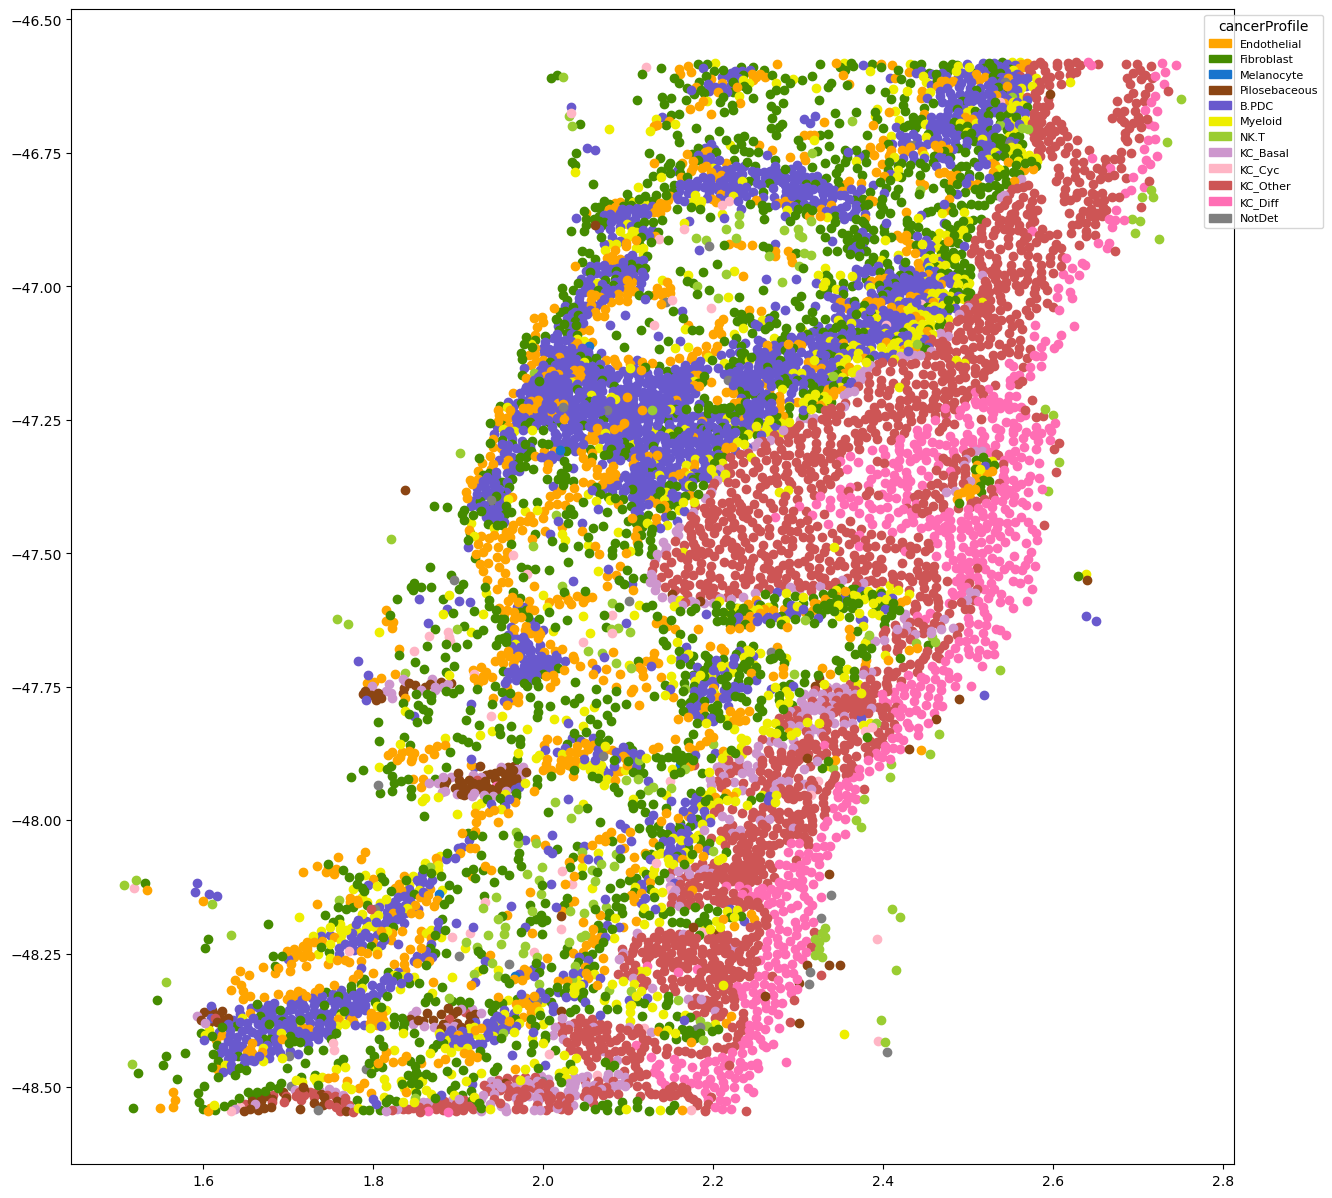

In [17]:
# fig2 = plt.figure(figsize = (20,20))
# ax3 = fig2.add_subplot(111)
# ax3.invert_yaxis()
# sc.pl.spatial(b18_subset_sub, color='cancerProfile', spot_size=0.02)#, ax=ax3)
# 
scatter_cell_plot(b18_subset_sub, 'sdimx','sdimy', 'cancerProfile', color_mapper=color2dict)

In [8]:
mel_subset = smi_anndata[smi_anndata.obs['Run_Tissue_name']=='48974-2B']


In [19]:
mel_subset.to_df()

,AATK,ABL1,ABL2,ACE,ACE2,ACKR1,ACKR3,ACKR4,ACTA2,ACTG2,...,WNT5B,WNT7A,WNT7B,WNT9A,XBP1,XCL1,XCL2,YBX3,YES1,ZFP36
cell_ID,,,,,,,,,,,,,,,,,,,,,
c_6_1_1,0.0,0.000000,0.000000,0.0,1.296860,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.890581,1.296860,0.000000,0.00000,0.0,3.890581,0.0,2.593721
c_6_1_2,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,9.413166,0.00000,0.0,4.706583,0.0,0.000000
c_6_1_3,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,2.327144,0.00000,0.0,2.327144,0.0,0.000000
c_6_1_4,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.0,1.193407
c_6_1_5,0.0,0.000000,0.785902,0.0,0.785902,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.785902,0.000000,0.000000,0.00000,0.0,1.571805,0.0,0.785902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c_6_17_634,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.000000
c_6_17_635,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.000000
c_6_17_637,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,20.685724,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.000000


In [20]:
mel_subset.to_df()[['CD44','AXL', 'MKI67']]

,CD44,AXL,MKI67
cell_ID,,,
c_6_1_1,0.000000,0.000000,0.0
c_6_1_2,0.000000,0.000000,0.0
c_6_1_3,0.000000,2.327144,0.0
c_6_1_4,0.000000,1.193407,0.0
c_6_1_5,0.785902,0.000000,0.0
...,...,...,...
c_6_17_634,0.000000,0.000000,0.0
c_6_17_635,0.000000,0.000000,0.0
c_6_17_637,0.000000,0.000000,0.0


In [21]:
mel_subset2 = mel_subset[(mel_subset[:,'CD44'].X>0).flatten(), :]
mel_subset2 = mel_subset2[(mel_subset2[:,'AXL'].X>0).flatten(), :]
mel_subset2 = mel_subset2[(mel_subset2[:,'MKI67'].X>0).flatten(), :]
mel_subset2

View of AnnData object with n_obs × n_vars = 451 × 960
    obs: 'sdimx', 'sdimy', 'ROI', 'fov', 'Area', 'AspectRatio', 'Width', 'Height', 'leiden_clus', 'IFcolor', 'dualfiles', 'ISH.concentration', 'slide_ID_numeric', 'Run_Tissue_name', 'Panel', 'Diversity', 'totalcounts', 'Slide_name', 'Run_name', 'tissue', 'healthyProfile', 'cancerProfile'
    obsm: 'spatial', 'umap'

In [22]:
mel_subset2.to_df()

,AATK,ABL1,ABL2,ACE,ACE2,ACKR1,ACKR3,ACKR4,ACTA2,ACTG2,...,WNT5B,WNT7A,WNT7B,WNT9A,XBP1,XCL1,XCL2,YBX3,YES1,ZFP36
cell_ID,,,,,,,,,,,,,,,,,,,,,
c_6_1_8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.612406,1.224813,0.000000,0.000000,0.000000,0.000000,1.837219,0.000000,0.000000
c_6_1_72,0.000000,0.000000,0.468029,0.000000,0.000000,0.000000,3.276203,0.000000,0.000000,0.000000,...,0.468029,0.000000,0.000000,0.468029,0.468029,0.936058,0.000000,1.872116,0.000000,0.000000
c_6_1_110,0.214593,0.214593,0.000000,0.214593,0.000000,0.000000,2.360525,0.429186,0.214593,0.000000,...,0.429186,0.643780,1.287559,1.931339,0.214593,0.858373,0.000000,4.077271,0.000000,0.214593
c_6_1_137,0.345901,0.000000,0.000000,0.345901,0.345901,0.000000,2.421306,0.691802,0.345901,0.345901,...,0.345901,0.345901,0.000000,0.691802,0.345901,1.037702,0.691802,4.150810,0.000000,0.000000
c_6_1_152,0.000000,0.000000,0.761611,0.000000,0.000000,0.761611,2.284832,0.000000,0.000000,0.000000,...,0.761611,0.000000,0.000000,2.284832,0.761611,2.284832,0.000000,2.284832,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c_6_17_386,0.000000,0.000000,0.583407,0.000000,0.000000,0.000000,1.750220,0.000000,0.000000,0.000000,...,0.000000,0.583407,1.166813,0.000000,0.000000,0.583407,0.583407,1.166813,0.000000,0.583407
c_6_17_399,0.000000,0.300492,0.000000,0.300492,0.000000,0.000000,1.201968,0.000000,0.000000,0.901476,...,0.000000,0.000000,0.000000,1.502460,0.000000,0.600984,0.600984,1.201968,0.000000,0.000000
c_6_17_404,0.168092,0.168092,0.168092,0.336185,0.000000,0.168092,2.017107,0.000000,0.168092,0.336185,...,0.168092,0.168092,0.840461,2.017107,0.000000,1.008554,0.168092,1.008554,0.168092,0.672369


In [23]:
mel_subset2.to_df()[['CD44','AXL', 'MKI67']]

,CD44,AXL,MKI67
cell_ID,,,
c_6_1_8,1.837219,0.612406,1.224813
c_6_1_72,0.468029,0.936058,0.468029
c_6_1_110,0.214593,0.429186,0.429186
c_6_1_137,0.691802,0.691802,0.345901
c_6_1_152,1.523221,0.761611,1.523221
...,...,...,...
c_6_17_386,2.333626,1.166813,0.583407
c_6_17_399,0.300492,0.300492,0.300492
c_6_17_404,0.840461,0.504277,1.344738


In [24]:
mel_subset2.obs

,sdimx,sdimy,ROI,fov,Area,AspectRatio,Width,Height,leiden_clus,IFcolor,...,slide_ID_numeric,Run_Tissue_name,Panel,Diversity,totalcounts,Slide_name,Run_name,tissue,healthyProfile,cancerProfile
cell_ID,,,,,,,,,,,,,,,,,,,,,
c_6_1_8,12.64444,-7.93198,c6_1,1,6530,1.29,123,95,2,#E49533FF,...,6,48974-2B,980p,243,684,S3,Run1069,48974-2B,KC_Diff,KC_Diff
c_6_1_72,12.30424,-7.96834,c6_1,1,4408,0.54,69,128,5,#FFAB73FF,...,6,48974-2B,980p,354,895,S3,Run1069,48974-2B,B.PDC,KC_Cyc
c_6_1_110,12.41008,-7.98130,c6_1,1,5900,1.33,104,78,5,#C8A81AFF,...,6,48974-2B,980p,585,1952,S3,Run1069,48974-2B,Endothelial,KC_Cyc
c_6_1_137,12.67594,-7.99120,c6_1,1,3875,1.50,99,66,5,#B3B700FF,...,6,48974-2B,980p,480,1211,S3,Run1069,48974-2B,Endothelial,KC_Cyc
c_6_1_152,12.55786,-7.99750,c6_1,1,3357,1.61,95,59,5,#825306FF,...,6,48974-2B,980p,295,550,S3,Run1069,48974-2B,Endothelial,KC_Cyc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c_6_17_386,18.02842,-1.17670,c6_17,17,3968,1.18,85,72,5,#578A13FF,...,6,48974-2B,980p,341,718,S3,Run1069,48974-2B,Fibroblast,Fibroblast
c_6_17_399,17.87452,-0.69916,c6_17,17,3045,0.97,71,73,5,#902C46FF,...,6,48974-2B,980p,586,1394,S3,Run1069,48974-2B,Endothelial,KC_Cyc
c_6_17_404,17.75734,-0.72400,c6_17,17,6771,1.83,146,80,5,#5D2800FF,...,6,48974-2B,980p,726,2492,S3,Run1069,48974-2B,Endothelial,KC_Cyc


In [25]:
for i in mel_subset2.obs.fov.unique():
    print(i)

1
2
3
8
9
11
12
13
14
15
16
17


In [9]:
mel_subset3 = mel_subset[mel_subset.obs.fov.isin([15])]

(<AxesSubplot: >, <Figure size 1400x900 with 1 Axes>)

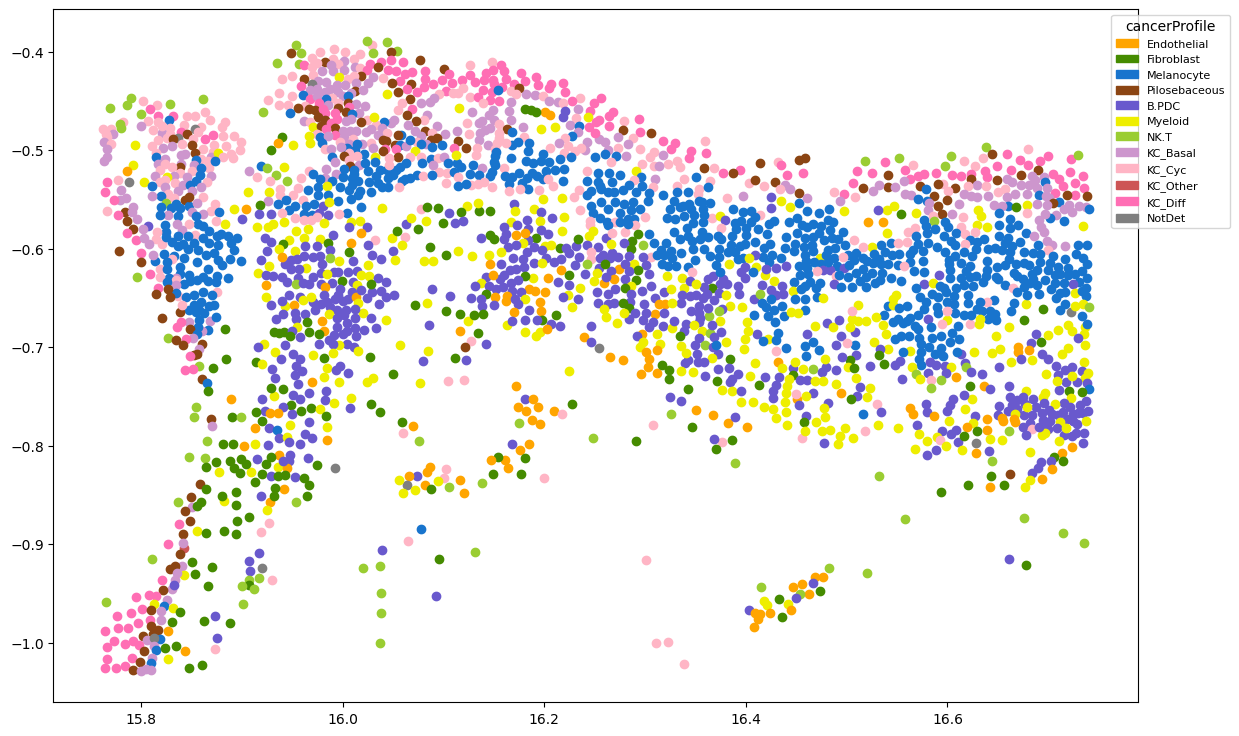

In [10]:

scatter_cell_plot(mel_subset3, 'sdimx','sdimy', 'cancerProfile', size=0.9, 
                  figsize=(14,9),
                  color_mapper=color2dict)

In [11]:
import squidpy as sq

In [12]:
mel_subset3

View of AnnData object with n_obs × n_vars = 2590 × 960
    obs: 'sdimx', 'sdimy', 'ROI', 'fov', 'Area', 'AspectRatio', 'Width', 'Height', 'leiden_clus', 'IFcolor', 'dualfiles', 'ISH.concentration', 'slide_ID_numeric', 'Run_Tissue_name', 'Panel', 'Diversity', 'totalcounts', 'Slide_name', 'Run_name', 'tissue', 'healthyProfile', 'cancerProfile'
    obsm: 'spatial', 'umap'

In [13]:
mel_subset4 = mel_subset3[((mel_subset3[:,'CD44'].X>0).flatten()) | 
                          ((mel_subset3[:,'AXL'].X>0).flatten()) | 
                          ((mel_subset3[:,'MKI67'].X>0).flatten())]
mel_subset4 

View of AnnData object with n_obs × n_vars = 1569 × 960
    obs: 'sdimx', 'sdimy', 'ROI', 'fov', 'Area', 'AspectRatio', 'Width', 'Height', 'leiden_clus', 'IFcolor', 'dualfiles', 'ISH.concentration', 'slide_ID_numeric', 'Run_Tissue_name', 'Panel', 'Diversity', 'totalcounts', 'Slide_name', 'Run_name', 'tissue', 'healthyProfile', 'cancerProfile'
    obsm: 'spatial', 'umap'

(<AxesSubplot: >, <Figure size 1400x900 with 1 Axes>)

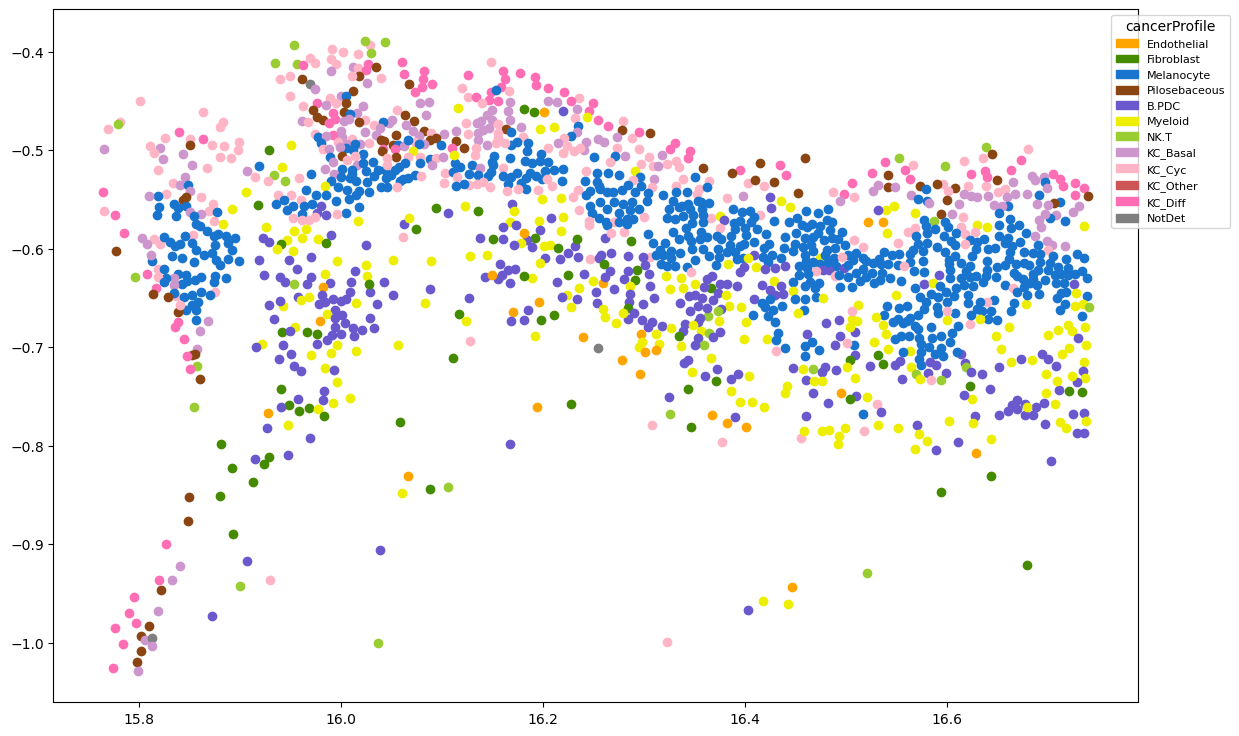

In [64]:
scatter_cell_plot(mel_subset4, 'sdimx','sdimy', 'cancerProfile', size=0.9, 
                  figsize=(14,9),
                  color_mapper=color2dict)

In [22]:
# import athena as ath
import networkx as nx
from scipy.spatial import Delaunay
# from spatialOmics import SpatialOmics

In [61]:
sq.gr.spatial_neighbors(mel_subset4)

In [63]:
sq.gr.nhood_enrichment(mel_subset4, cluster_key="cancerProfile",n_perms=1000)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 239.04/s]


In [15]:
labels = pd.Categorical(mel_subset3.obs['cancerProfile'].cat.categories)

In [16]:
mel_subset3 

View of AnnData object with n_obs × n_vars = 2590 × 960
    obs: 'sdimx', 'sdimy', 'ROI', 'fov', 'Area', 'AspectRatio', 'Width', 'Height', 'leiden_clus', 'IFcolor', 'dualfiles', 'ISH.concentration', 'slide_ID_numeric', 'Run_Tissue_name', 'Panel', 'Diversity', 'totalcounts', 'Slide_name', 'Run_name', 'tissue', 'healthyProfile', 'cancerProfile'
    obsm: 'spatial', 'umap'

In [17]:
def summarise_nhood_enrichments(ID, zscore_df):
    enrichments = {}
    for source_cell in zscore_df.index:
        for target_cell in zscore_df.columns:
            zscore = zscore_df.loc[source_cell][target_cell]
            new_key = f'{source_cell} - {target_cell}'
            new_key_inverse = f'{target_cell} - {source_cell}'
            if new_key_inverse in enrichments.keys():
                # Check that matrix is symmetric
                assert enrichments[new_key_inverse] == [zscore]
            else:
                enrichments[new_key] = [zscore]
    return pd.DataFrame.from_dict(enrichments, orient='index', columns=[ID])

In [55]:
mel_subset3.obs

,sdimx,sdimy,ROI,fov,Area,AspectRatio,Width,Height,leiden_clus,IFcolor,...,slide_ID_numeric,Run_Tissue_name,Panel,Diversity,totalcounts,Slide_name,Run_name,tissue,healthyProfile,cancerProfile
cell_ID,,,,,,,,,,,,,,,,,,,,,
c_6_15_1,16.02890,-0.39318,c6_15,15,4064,2.15,127,59,7,#8A4226FF,...,6,48974-2B,980p,142,162,S3,Run1069,48974-2B,Endothelial,KC_Cyc
c_6_15_2,15.99128,-0.39714,c6_15,15,5943,1.40,116,83,5,#816C1AFF,...,6,48974-2B,980p,324,453,S3,Run1069,48974-2B,Endothelial,KC_Cyc
c_6_15_3,16.05338,-0.39912,c6_15,15,5987,1.60,142,89,5,#773613FF,...,6,48974-2B,980p,133,284,S3,Run1069,48974-2B,Endothelial,NK.T
c_6_15_4,16.02980,-0.40110,c6_15,15,4202,1.92,121,63,5,#8D680DFF,...,6,48974-2B,980p,286,396,S3,Run1069,48974-2B,Endothelial,NK.T
c_6_15_5,16.04762,-0.40074,c6_15,15,2877,2.45,125,51,2,#614406FF,...,6,48974-2B,980p,73,91,S3,Run1069,48974-2B,KC_Diff,Pilosebaceous
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c_6_15_2636,15.87266,-1.00644,c6_15,15,4304,0.82,69,84,4,#240C06FF,...,6,48974-2B,980p,24,33,S3,Run1069,48974-2B,NotDet,KC_Cyc
c_6_15_2637,15.84368,-1.00842,c6_15,15,6555,0.90,88,98,7,#5A1506FF,...,6,48974-2B,980p,89,109,S3,Run1069,48974-2B,Fibroblast,Endothelial
c_6_15_2640,15.82604,-1.01688,c6_15,15,4797,0.87,76,87,4,#391A06FF,...,6,48974-2B,980p,37,71,S3,Run1069,48974-2B,Myeloid,Myeloid


In [58]:
nhood_zscore = mel_subset3.uns['cancerProfile_nhood_enrichment']['zscore']
metadata = mel_subset3.obs.fov
nhood_zscore_df = pd.DataFrame(nhood_zscore, index=labels, columns=labels)
# nhood_enrichments = summarise_nhood_enrichments(metadata, nhood_zscore_df)

In [59]:
nhood_zscore_df

,B.PDC,Endothelial,Fibroblast,KC_Basal,KC_Cyc,KC_Diff,KC_Other,Melanocyte,Myeloid,NK.T,NotDet,Pilosebaceous
B.PDC,33.671591,9.857029,9.106682,-15.493720,-15.048480,-14.698708,-1.199345,-25.802847,19.269772,-1.649915,-0.939915,-11.880116
Endothelial,8.921878,22.913756,9.577214,-7.665571,-5.723782,-7.142153,-0.516583,-14.395282,3.211098,4.526584,2.951987,-5.543874
Fibroblast,7.785171,7.523851,18.075176,-8.107058,-7.836419,-8.258380,1.157712,-15.383888,4.372914,3.257845,0.399721,-4.189842
KC_Basal,-15.520810,-7.889221,-6.296327,28.229650,10.160288,3.543883,2.107720,-6.680309,-9.313828,-5.422446,1.163454,14.395887
KC_Cyc,-14.431130,-7.680196,-7.507198,9.405594,17.542092,2.219285,-0.897939,-2.276021,-6.683923,2.998949,1.310346,3.156658
KC_Diff,-14.365982,-7.000287,-8.322135,2.049092,3.250827,42.642505,1.010395,-14.975715,-10.533025,4.210476,-1.046772,20.418599
KC_Other,-1.132737,-0.509332,4.359050,0.676392,-0.882647,1.025892,NaN,-1.306642,0.335478,-0.461266,-0.153432,3.147652
Melanocyte,-25.017417,-14.959714,-15.345085,-6.391068,-0.127164,-15.300776,-1.376276,59.477863,-12.548583,-9.276750,-3.481247,-10.145766
Myeloid,16.134556,3.749971,5.944829,-10.547825,-8.048755,-10.731410,-0.972826,-14.984530,13.296825,-3.687404,0.984845,-8.161251
NK.T,-2.756967,0.874129,1.667645,-5.323638,-0.967733,-1.543280,-0.470960,-9.663435,-4.754899,14.478368,-0.099824,-0.310691


In [ ]:
# nhood_enrichment_summary = pd.concat(nhood_enrichments, axis=1)

In [55]:
# scatter_cell_plot(mel_subset, 'sdimx','sdimy', 'cancerProfile', color_mapper=color2dict)
mel_subset4 = mel_subset3[(mel_subset3[:,'CD44'].X>0).flatten(), :]
mel_subset4 = mel_subset4[(mel_subset4[:,'AXL'].X>0).flatten(), :]
mel_subset4 = mel_subset4[(mel_subset4[:,'MKI67'].X>0).flatten(), :]
mel_subset4

View of AnnData object with n_obs × n_vars = 96 × 960
    obs: 'sdimx', 'sdimy', 'ROI', 'fov', 'Area', 'AspectRatio', 'Width', 'Height', 'leiden_clus', 'IFcolor', 'dualfiles', 'ISH.concentration', 'slide_ID_numeric', 'Run_Tissue_name', 'Panel', 'Diversity', 'totalcounts', 'Slide_name', 'Run_name', 'tissue', 'healthyProfile', 'cancerProfile'
    obsm: 'spatial', 'umap'

In [59]:
mel_subset4.to_df()[['CD44','AXL', 'MKI67']].index

Index(['c_6_15_11', 'c_6_15_39', 'c_6_15_45', 'c_6_15_96', 'c_6_15_244',
       'c_6_15_255', 'c_6_15_260', 'c_6_15_305', 'c_6_15_354', 'c_6_15_373',
       'c_6_15_381', 'c_6_15_400', 'c_6_15_407', 'c_6_15_442', 'c_6_15_444',
       'c_6_15_459', 'c_6_15_512', 'c_6_15_533', 'c_6_15_534', 'c_6_15_545',
       'c_6_15_556', 'c_6_15_570', 'c_6_15_585', 'c_6_15_591', 'c_6_15_597',
       'c_6_15_604', 'c_6_15_617', 'c_6_15_629', 'c_6_15_643', 'c_6_15_649',
       'c_6_15_659', 'c_6_15_677', 'c_6_15_690', 'c_6_15_708', 'c_6_15_727',
       'c_6_15_745', 'c_6_15_769', 'c_6_15_786', 'c_6_15_807', 'c_6_15_821',
       'c_6_15_846', 'c_6_15_899', 'c_6_15_920', 'c_6_15_925', 'c_6_15_951',
       'c_6_15_965', 'c_6_15_974', 'c_6_15_994', 'c_6_15_1000', 'c_6_15_1019',
       'c_6_15_1036', 'c_6_15_1060', 'c_6_15_1100', 'c_6_15_1178',
       'c_6_15_1179', 'c_6_15_1204', 'c_6_15_1208', 'c_6_15_1258',
       'c_6_15_1265', 'c_6_15_1313', 'c_6_15_1422', 'c_6_15_1435',
       'c_6_15_1450', 'c_6_15_1

In [61]:
expression_matrix_fov15 = mel_subset4.to_df()[['CD44','AXL', 'MKI67']]
expression_matrix_fov15

,CD44,AXL,MKI67
cell_ID,,,
c_6_15_11,2.353292,4.706583,2.353292
c_6_15_39,1.419952,1.419952,1.419952
c_6_15_45,0.712997,0.356499,1.069496
c_6_15_96,0.875720,0.291907,0.291907
c_6_15_244,0.651456,0.325728,0.325728
...,...,...,...
c_6_15_2398,3.650422,0.912605,0.912605
c_6_15_2417,1.331205,0.443735,1.331205
c_6_15_2431,0.775715,0.775715,0.387857


(<AxesSubplot: >, <Figure size 1400x900 with 1 Axes>)

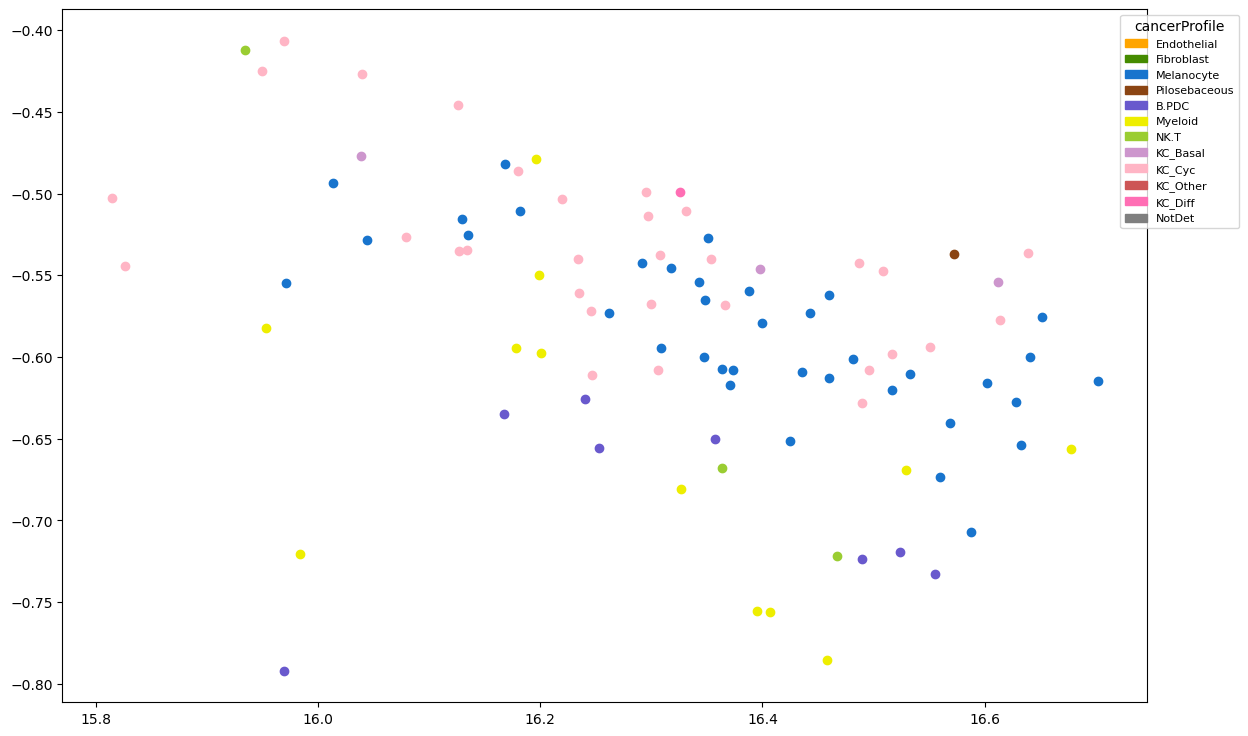

In [56]:
scatter_cell_plot(mel_subset4, 'sdimx','sdimy', 'cancerProfile', 
                  size=0.9, 
                  figsize=(14,9),
                  color_mapper=color2dict)

In [70]:
from scipy.spatial import Delaunay

In [73]:
mel_subset4.obs[['sdimx', 'sdimy']]

,sdimx,sdimy
cell_ID,,
c_6_15_1,16.02890,-0.39318
c_6_15_2,15.99128,-0.39714
c_6_15_4,16.02980,-0.40110
c_6_15_6,16.00226,-0.40002
c_6_15_7,16.01702,-0.40290
...,...,...
c_6_15_2599,16.52030,-0.92904
c_6_15_2603,15.82010,-0.93624
c_6_15_2608,15.79508,-0.95352


In [74]:
tri = Delaunay(mel_subset4.obs[['sdimx', 'sdimy']])

In [69]:
mel_subset4.write_h5ad('filtered_cell.h5ad')

In [45]:
# test = sq.datasets.imc()

In [46]:
# test

In [27]:
test.to_df()

,1021522Tm169Di EGFR,1031747Er167Di ECadhe,112475Gd156Di Estroge,117792Dy163Di GATA3,1261726In113Di Histone,1441101Er168Di Ki67,174864Nd148Di SMA,1921755Sm149Di Vimenti,198883Yb176Di cleaved,201487Eu151Di cerbB,...,71790Dy162Di CD45,77877Nd146Di CD68,8001752Sm152Di CD3epsi,92964Er166Di Carboni,971099Nd144Di Cytoker,98922Yb174Di Cytoker,phospho Histone,phospho S6,phospho mTOR,Area
0,1.061895,8.085332,0.337812,0.321856,22.676172,0.068810,0.364338,0.094569,1.669934,4.350186,...,0.160391,0.192944,0.033263,1.481392,0.126192,0.081556,0.564968,1.468315,1.761658,55.0
1,1.010395,8.308472,0.320835,0.224368,14.195655,0.021648,0.553934,0.036734,1.457793,3.211087,...,0.160315,0.094140,0.156084,0.979076,0.122359,0.139130,0.305365,1.024873,1.616977,93.0
2,1.077522,5.274055,0.922280,0.628528,33.087868,0.046367,1.708991,0.000000,1.232840,0.745345,...,0.004864,0.130166,0.000000,2.007145,0.514660,0.000000,0.465301,2.192775,2.067328,15.0
3,1.576723,11.119562,0.576232,0.312170,23.579065,0.195567,6.628324,0.000000,1.552365,3.856008,...,0.181149,0.320298,0.094284,1.313890,0.403974,0.000000,0.140070,0.265316,2.366359,18.0
4,0.702806,8.522112,0.428847,0.197394,20.523558,0.199734,3.194194,0.933255,1.943893,3.115766,...,0.311178,0.499227,0.270265,1.405548,0.488878,0.042310,0.241761,0.615953,1.980837,56.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4707,0.625143,5.911421,0.601428,0.320534,13.650654,0.057998,0.111695,0.000000,1.593383,3.332439,...,0.008074,0.079715,0.062850,1.399778,0.095043,0.000000,0.149433,2.722149,2.060011,34.0
4708,1.021963,3.117383,0.272802,0.158449,14.322868,0.180664,0.210680,0.063195,1.713520,5.943739,...,0.060717,0.214405,0.204475,1.775037,0.087685,0.000000,0.155141,0.435964,2.776099,19.0
4709,0.620875,3.037405,0.241602,0.394792,15.694256,0.131815,0.493719,0.000000,1.652438,3.803927,...,0.139092,0.051660,0.049747,1.206817,0.099784,0.069096,0.209134,0.386426,1.760313,28.0
4710,0.766836,4.233937,0.065262,0.097693,19.958614,1.629305,0.122124,0.279252,1.358616,2.651239,...,0.226655,0.144621,0.117215,1.266033,0.100777,0.037203,0.418111,0.626131,1.748487,24.0


In [ ]:
# test.obs

In [30]:
test.obsm['spatial']

array([[  1.70909091,  15.32727273],
       [  3.84946237,  42.07526882],
       [  0.86666667,  50.33333333],
       ...,
       [730.14285714, 636.96428571],
       [730.375     , 658.04166667],
       [729.87628866, 679.63917526]])

In [33]:
sq.pl.spatial_scatter(test, color="cell type")

KeyError: "Spatial key 'spatial' not found in `adata.uns`."